# Example of generation of valid data mask using a predicate

Notebook showing an example of predicate for generation of valid data mask 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime

from sentinelhub import BBox, CRS

from eolearn.core.eoworkflow import LinearWorkflow, Dependency
from eolearn.core.eodata import FeatureType
from eolearn.io import S2L1CWCSInput
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask

Define ROI BBOX and time interval

In [2]:
roi_bbox = BBox(bbox=[5.60, 52.68, 5.75, 52.63], crs=CRS.WGS84)
time_interval = ('2017-04-01', '2017-05-31')

### Workflow to merge the cloud mask with the mask defining where reflectance data is available

The predicate merges the cloud mask with the `IS_DATA` mask which defines where reflectance data is available. For orbits covering partially the ROI, the `IS_DATA` mask values will be 0.

In [3]:
class ValidDataPredicate:
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

In [4]:
layer = 'BANDS-S2-L1C'

input_task = S2L1CWCSInput(layer=layer, 
                           resx='20m', resy='20m', 
                           maxcc=1, time_difference=datetime.timedelta(hours=2))

cloud_classifier = get_s2_pixel_cloud_detector(all_bands=True)
add_clm = AddCloudMaskTask(cloud_classifier, 
                           'BANDS-S2-L1C', 
                           cm_size_y='60m', 
                           cm_size_x='60m', 
                           cmask_feature='CLM',
                           cprobs_feature='CLP')

add_valmask = AddValidDataMaskTask(predicate=ValidDataPredicate())

Finished loading model, total used 170 iterations


Run workflow

In [5]:
workflow = LinearWorkflow(input_task,add_clm, add_valmask)
result = workflow.execute({
    input_task: {
        'bbox': roi_bbox,
        'time_interval': time_interval
    }
})

Plot results

In [6]:
eopatch = result[add_valmask]

eopatch

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(12, 278, 506, 13), dtype=float32)
    CLP: numpy.ndarray(shape=(12, 278, 506, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 278, 506, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(12, 278, 506, 1), dtype=uint8)
    VALID_DATA: numpy.ndarray(shape=(12, 278, 506, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(0, 7200)
    time_interval: [datetime.datetime(2017, 4, 1, 0, 0), datetime.datetime(2017, 5, 31, 0, 0)]
  }
  bbox: BBox(((5.6, 52.63), (5.75, 52.68)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2017, 4, 3, 10, 41, 38), ..., datetime.datetime(2017, 5, 26, 10, 55, 18)], length=12
)

Display the input masks (`IS_DATA` mask on the left and cloud mask `CLM` in the middle) and the resulting merged mask (`VALID_DATA` on the right)

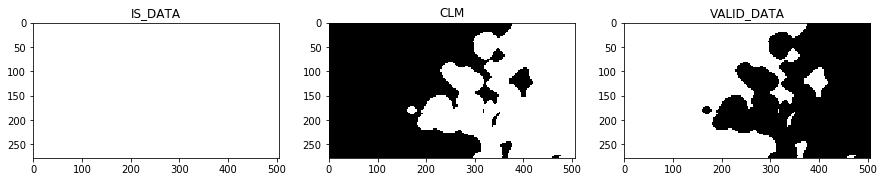

In [7]:
tidx = 5
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(eopatch.mask['IS_DATA'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.title('IS_DATA')
plt.subplot(132)
plt.imshow(eopatch.mask['CLM'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.title('CLM')
plt.subplot(133)
plt.imshow(eopatch.mask['VALID_DATA'][tidx].squeeze(), vmin=0, vmax=1, cmap='gray')
plt.title('VALID_DATA');